In [2]:
!pip install tensorflow keras matplotlib numpy pandas split-folders

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

Dataset (source, sample,  EDA, preprocessing)


1. Source of Dataset

In [3]:
from google.colab import drive
DATASET_SOURCE = "Mendeley Data: https://data.mendeley.com/datasets/n3gtgm9jxj/2"
drive.mount('/content/drive')

zip_file_path = '/content/drive/MyDrive/NNFLL Project/Waste Dataset.zip'

Mounted at /content/drive


In [6]:
import zipfile
import os
extract_dir = '/content/Waste Dataset/'
os.makedirs(extract_dir, exist_ok=True)
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Successfully extracted '{zip_file_path}' to '{extract_dir}'")
except FileNotFoundError:
    print(f"Error: The file '{zip_file_path}' was not found. Please ensure Google Drive is mounted and the path is correct.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")

Successfully extracted '/content/drive/MyDrive/NNFLL Project/Waste Dataset.zip' to '/content/Waste Dataset/'


In [7]:

from PIL import Image
def check_folder(folder_path):
    valid_images = []
    invalid_files = []

    for root, dirs, files in os.walk(folder_path):
        for f in files:
            file_path = os.path.join(root, f)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Validate image
                valid_images.append(file_path)
            except:
                invalid_files.append(file_path)

    print(f"Total valid images: {len(valid_images)}")
    print(f"Total invalid files: {len(invalid_files)}")

    if invalid_files:
        print("\nInvalid Files:")
        for file in invalid_files:
            print(file)

    return valid_images

image_folder = "/content/Waste Dataset"
valid_images = check_folder(image_folder)


Total valid images: 24705
Total invalid files: 0


In [ ]:
print("Dataset Information:")
display(df.info())

print("First 5 rows of the dataset:")
display(df.head())

print("Descriptive statistics of the dataset:")
display(df.describe())

2. Sample

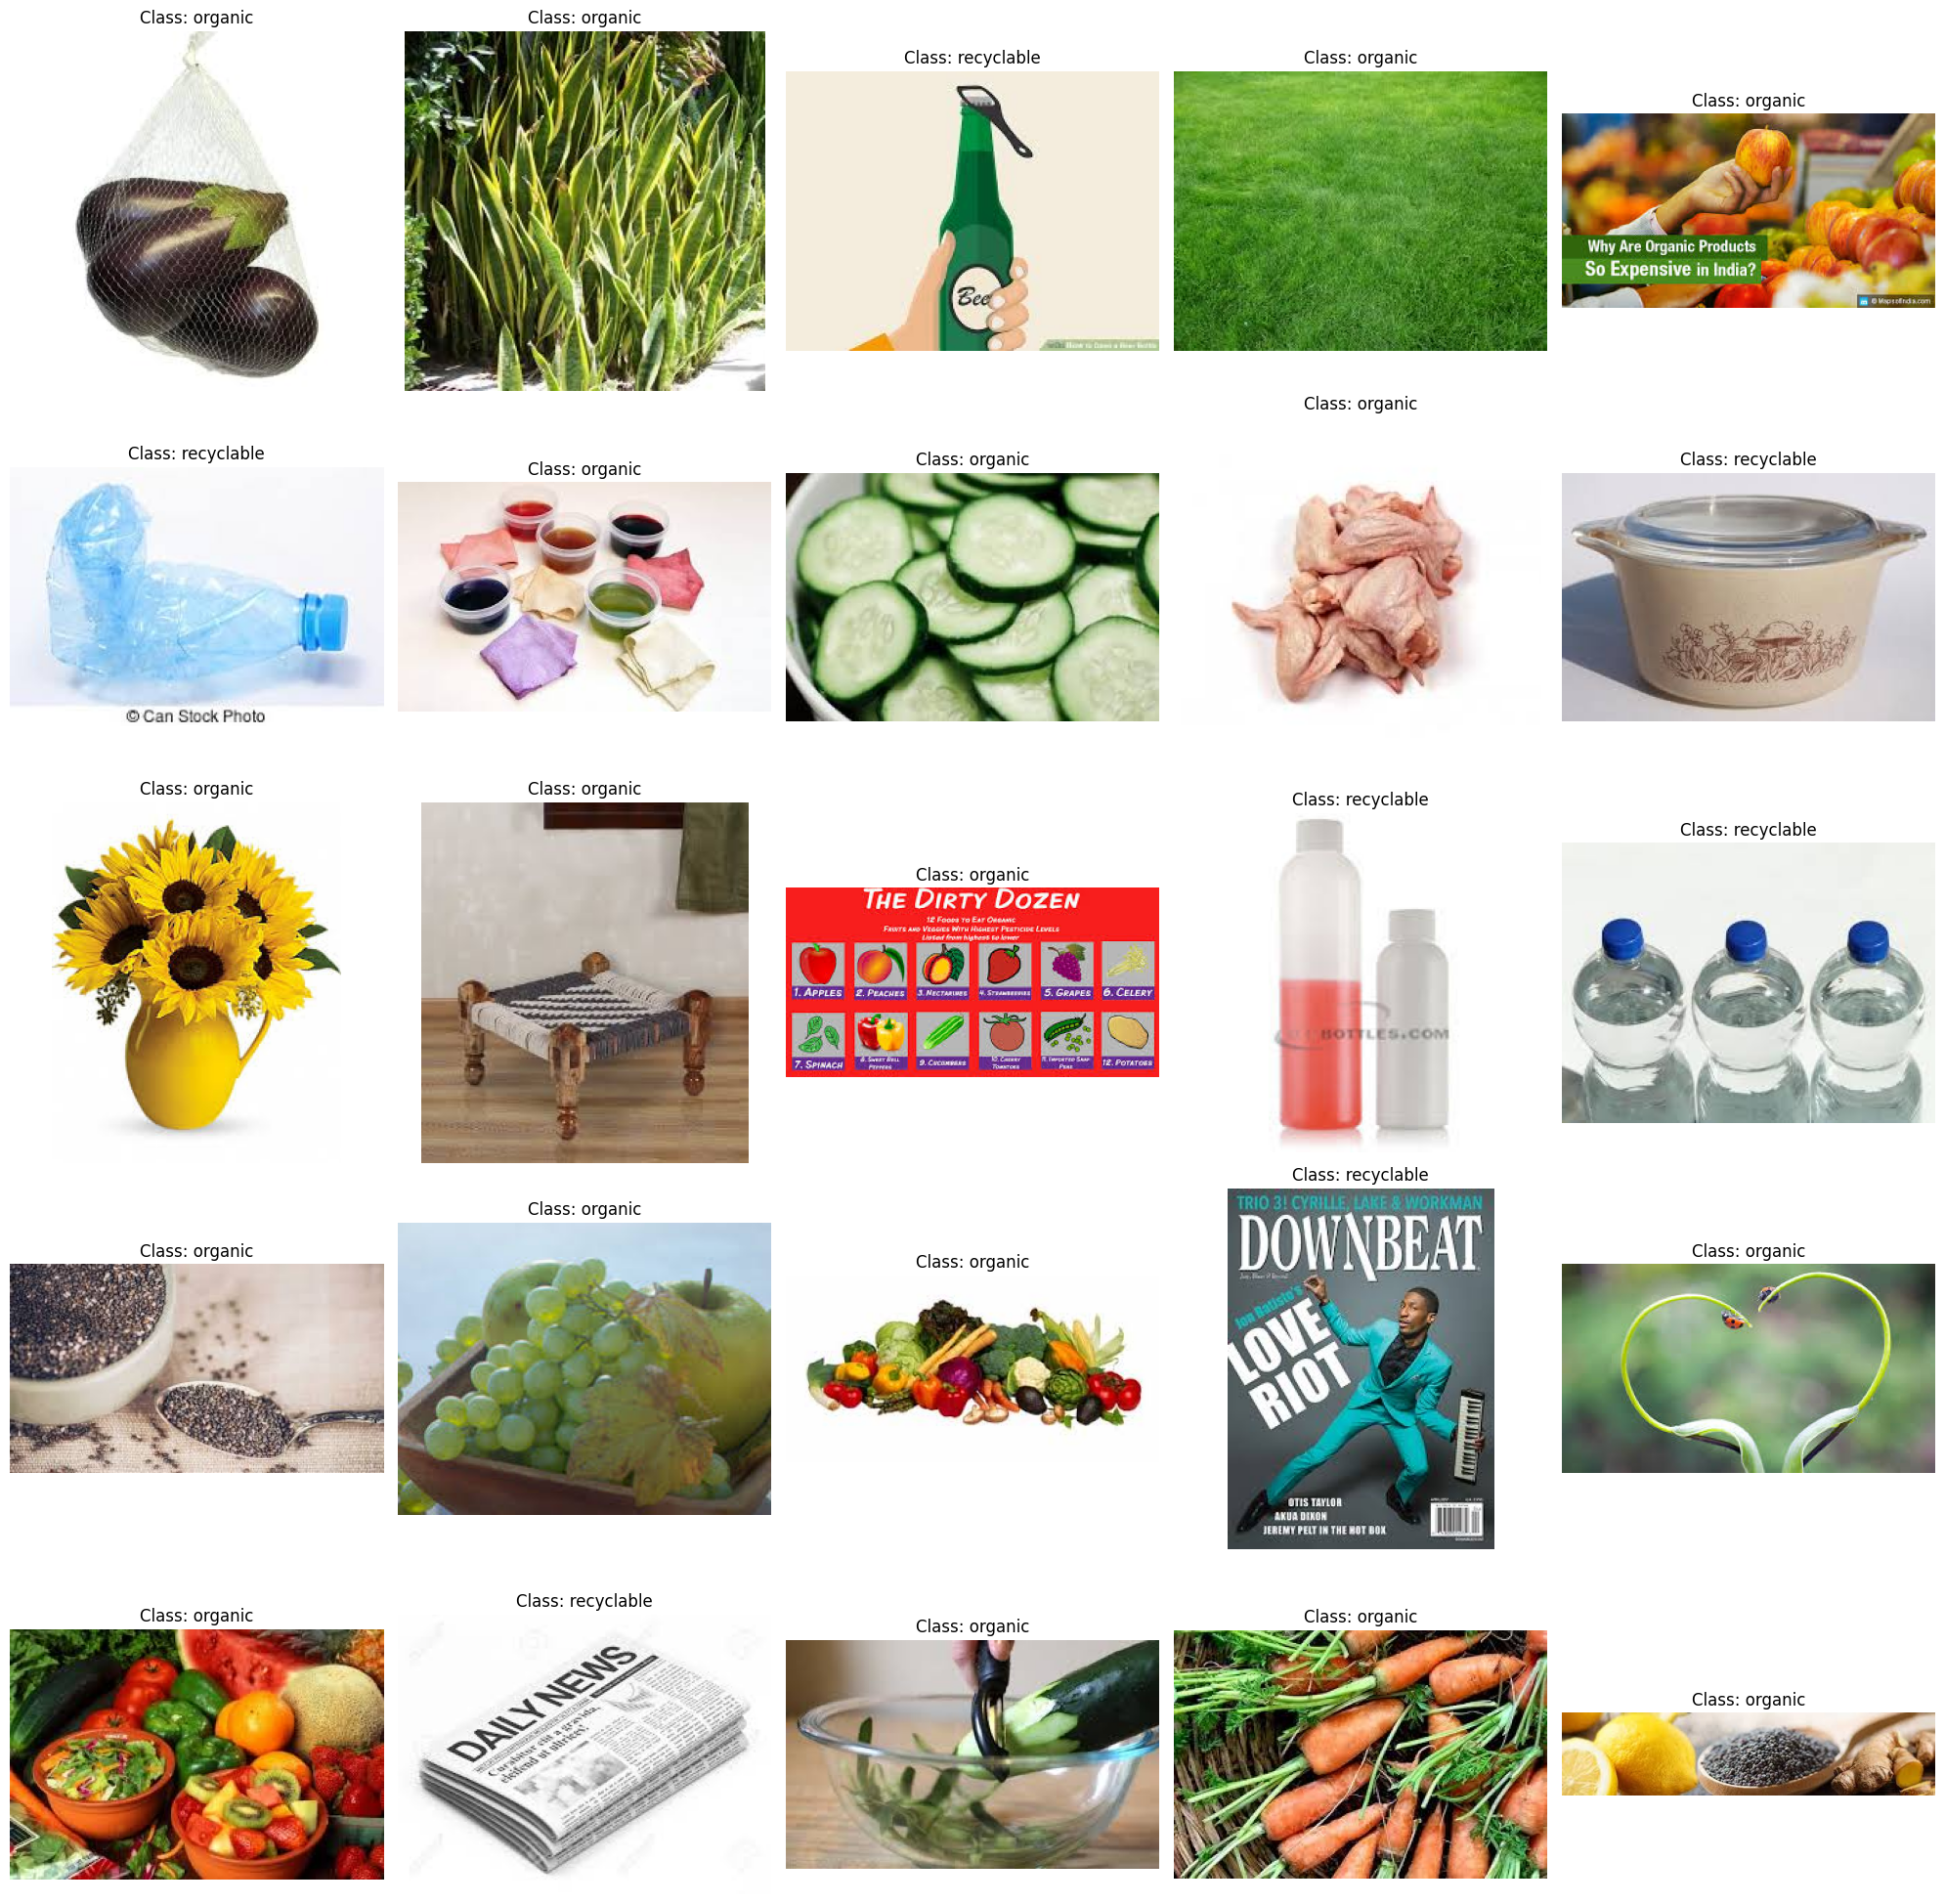

In [11]:
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
base_dataset_dir = '/content/Waste Dataset/Waste Dataset/'
class_names = [d for d in os.listdir(base_dataset_dir) if os.path.isdir(os.path.join(base_dataset_dir, d))]
all_image_paths_with_classes = []
for class_name in class_names:
    class_path = os.path.join(base_dataset_dir, class_name)
    image_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    for img_path in image_files:
        all_image_paths_with_classes.append({'path': img_path, 'class': class_name})
random.shuffle(all_image_paths_with_classes)

num_images_to_display = 25
sample_images = all_image_paths_with_classes[:min(num_images_to_display, len(all_image_paths_with_classes))]

num_cols = 5
num_rows = (len(sample_images) + num_cols - 1) // num_cols

plt.figure(figsize=(num_cols * 4, num_rows * 4))

for i, img_data in enumerate(sample_images):
    ax = plt.subplot(num_rows, num_cols, i + 1)
    img = Image.open(img_data['path'])
    ax.imshow(img)
    ax.set_title(f"Class: {img_data['class']}")
    ax.axis('off')

plt.tight_layout()
plt.show()

3. Exploratory Data Analysis (EDA)

In [13]:
class_counts = {}
for class_name in class_names:
    class_path = os.path.join(base_dataset_dir, class_name)
    class_counts[class_name] = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
print("Image counts per class:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

Image counts per class:
recyclable: 10825 images
organic: 13880 images


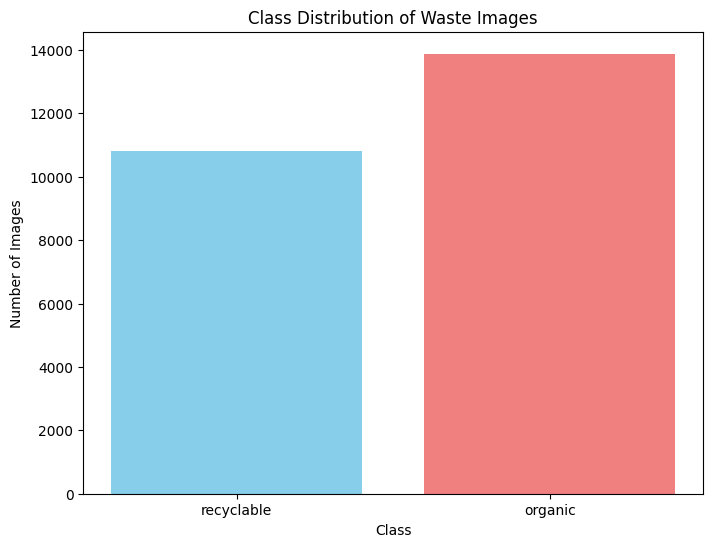

In [18]:
class_names = list(class_counts.keys())
image_counts = list(class_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(class_names, image_counts, color=['skyblue', 'lightcoral'])
plt.title('Class Distribution of Waste Images')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

In [16]:
def get_image_dimensions(image_path):
    try:
        with Image.open(image_path) as img:
            width, height = img.size
            channels = len(img.getbands())
            return width, height, channels
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

print("Defined function 'get_image_dimensions' to retrieve image dimensions safely.")

Defined function 'get_image_dimensions' to retrieve image dimensions safely.


In [17]:
sample_size = 100 # Number of images to sample
sampled_image_data = random.sample(all_image_paths_with_classes, min(sample_size, len(all_image_paths_with_classes)))

image_dimensions = []
print(f"Analyzing dimensions for a sample of {len(sampled_image_data)} images:\n")

for i, img_data in enumerate(sampled_image_data):
    path = img_data['path']
    dimensions = get_image_dimensions(path)
    if dimensions:
        width, height, channels = dimensions
        image_dimensions.append({'path': path, 'class': img_data['class'], 'width': width, 'height': height, 'channels': channels})
        print(f"  {i+1}. Image: {os.path.basename(path)}, Class: {img_data['class']}, Dimensions: {width}x{height}x{channels}")

if image_dimensions:
    widths = [d['width'] for d in image_dimensions]
    heights = [d['height'] for d in image_dimensions]

    min_width = min(widths)
    max_width = max(widths)
    avg_width = np.mean(widths)

    min_height = min(heights)
    max_height = max(heights)
    avg_height = np.mean(heights)

    print(f"\n--- Dimension Summary (based on {len(image_dimensions)} sampled images) ---")
    print(f"Width:  Min={min_width}, Max={max_width}, Avg={avg_width:.2f}")
    print(f"Height: Min={min_height}, Max={max_height}, Avg={avg_height:.2f}")
else:
    print("No valid image dimensions were collected from the sample.")

Analyzing dimensions for a sample of 100 images:

  1. Image: organic_006871_photo.jpg, Class: organic, Dimensions: 225x225x3
  2. Image: recyclable_005532_photo.jpg, Class: recyclable, Dimensions: 225x225x3
  3. Image: recyclable_005116_photo.jpg, Class: recyclable, Dimensions: 225x225x3
  4. Image: organic_002081_photo.jpg, Class: organic, Dimensions: 276x183x3
  5. Image: recyclable_001439_photo.jpg, Class: recyclable, Dimensions: 275x183x3
  6. Image: recyclable_001856_photo.jpg, Class: recyclable, Dimensions: 225x225x3
  7. Image: recyclable_006302_photo.jpg, Class: recyclable, Dimensions: 299x169x3
  8. Image: recyclable_001449_photo.jpg, Class: recyclable, Dimensions: 379x133x3
  9. Image: organic_006408_photo.jpg, Class: organic, Dimensions: 275x183x3
  10. Image: recyclable_004174_photo.jpg, Class: recyclable, Dimensions: 276x183x3
  11. Image: organic_003243_photo.jpg, Class: organic, Dimensions: 275x183x3
  12. Image: organic_012556_photo.jpg, Class: organic, Dimensions: 275

4. Data Preprocessing

In [20]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255)


processed_data_generator = datagen.flow_from_directory(
    base_dataset_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

print(f"Image preprocessing setup complete. Images will be resized to {IMG_HEIGHT}x{IMG_WIDTH} and normalized.")
print(f"Found {processed_data_generator.samples} images belonging to {processed_data_generator.num_classes} classes.")

Found 24705 images belonging to 2 classes.
Image preprocessing setup complete. Images will be resized to 224x224 and normalized.
Found 24705 images belonging to 2 classes.


In [21]:
import splitfolders
output_dir = 'splitted_dataset'
splitfolders.ratio(base_dataset_dir, output=output_dir, seed=42, ratio=(.7, .15, .15), group_prefix=None)
print(f"Dataset split into train, validation, and test sets in '{output_dir}'")

Copying files: 24705 files [00:09, 2713.88 files/s]

Dataset split into train, validation, and test sets in 'splitted_dataset'


In [42]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    os.path.join(output_dir, 'train'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
validation_generator = validation_datagen.flow_from_directory(
    os.path.join(output_dir, 'val'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(output_dir, 'test'),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Data generators created for training, validation, and testing. Each will resize images to {IMG_HEIGHT}x{IMG_WIDTH} and normalize pixel values.")

Found 17293 images belonging to 2 classes.
Found 3705 images belonging to 2 classes.
Found 3707 images belonging to 2 classes.
Data generators created for training, validation, and testing. Each will resize images to 224x224 and normalize pixel values.


In [24]:
from sklearn.utils.class_weight import compute_class_weight
train_labels = train_generator.classes

unique_classes = list(train_generator.class_indices.keys())
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_indices = train_generator.class_indices
class_weights = {
    class_indices[class_name]: weight
    for class_name, weight in zip(unique_classes, class_weights_array)
}

print("Calculated Class Weights:", class_weights)

Calculated Class Weights: {0: np.float64(0.8899238369699465), 1: np.float64(1.1411508512603934)}


Methodology


model architecture


In [40]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

print("CNN model architecture defined.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


CNN model architecture defined.


In [41]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("CNN model compiled with Adam optimizer, categorical cross-entropy loss, and accuracy metric.")

CNN model compiled with Adam optimizer, categorical cross-entropy loss, and accuracy metric.


In [29]:
model.summary()
print("Model summary displayed.")

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

Model summary displayed.


hyperparameters


In [33]:
EPOCHS = 5
LEARNING_RATE = 0.001
BATCH_SIZE = 32
DROPOUT_RATE = 0.5

print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Dropout Rate: {DROPOUT_RATE}")

Epochs: 5
Learning Rate: 0.001
Batch Size: 32
Dropout Rate: 0.5


fine-tuning

In [44]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_finetuned_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, model_checkpoint]
)

print("Model training complete.")

Epoch 1/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8581 - loss: 0.3329
Epoch 1: val_accuracy improved from -inf to 0.86114, saving model to best_finetuned_model.keras
540/540 ━━━━━━━━━━━━━━━━━━━━ 1338s 2s/step - accuracy: 0.8581 - loss: 0.3329 - val_accuracy: 0.8611 - val_loss: 0.3470
Epoch 2/5
  1/540 ━━━━━━━━━━━━━━━━━━━━ 20:26 2s/step - accuracy: 0.8125 - loss: 0.4924

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.86114
540/540 ━━━━━━━━━━━━━━━━━━━━ 135s 247ms/step - accuracy: 0.8125 - loss: 0.4924 - val_accuracy: 0.8535 - val_loss: 0.3783
Epoch 3/5
540/540 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8746 - loss: 0.3002
Epoch 3: val_accuracy improved from 0.86114 to 0.86277, saving model to best_finetuned_model.keras
540/540 ━━━━━━━━━━━━━━━━━━━━ 1385s 3s/step - accuracy: 0.8747 - loss: 0.3002 - val_accuracy: 0.8628 - val_loss: 0.3706
Epoch 4/5
  1/540 ━━━━━━━━━━━━━━━━━━━━ 21:50 2s/step - accuracy: 0.7812 - loss: 0.5744
Epoch 4: val_accuracy did not improve from 0.86277
540/540 ━━━━━━━━━━━━━━━━━━━━ 83s 150ms/step - accuracy: 0.7812 - loss: 0.5744 - val_accuracy: 0.8511 - val_loss: 0.3946
Model training complete.


Training procedure

In [46]:
import matplotlib.pyplot as plt

def plot_history(hist, title):
    plt.figure(figsize=(12,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()


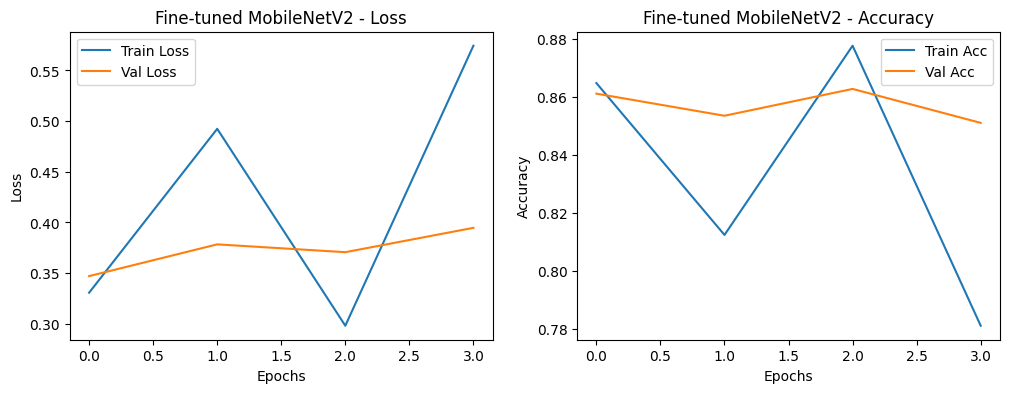

In [71]:

plot_history(history, 'Fine-tuned MobileNetV2')

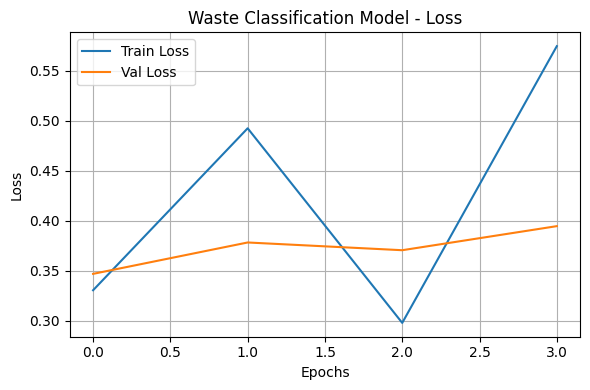

In [60]:

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Waste Classification Model - Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

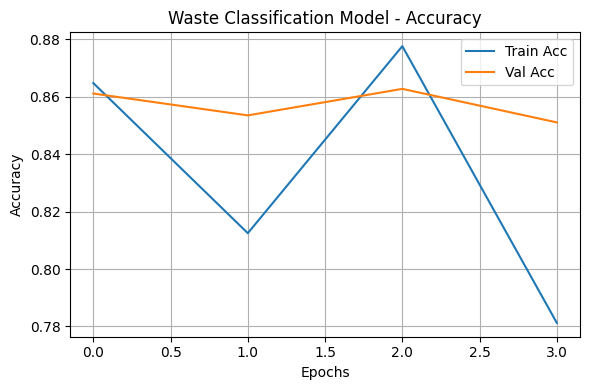

In [59]:

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Waste Classification Model - Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

optimizers

In [50]:
print(f"The current model uses the loss function: {model.loss}")

The current model uses the loss function: categorical_crossentropy


In [52]:
print(f"The current model uses the optimizer: {model.optimizer.__class__.__name__}")

The current model uses the optimizer: Adam


seeds

In [62]:

output_dir = 'splitted_dataset'
splitfolders.ratio(base_dataset_dir, output=output_dir, seed=42, ratio=(.7, .15, .15), group_prefix=None)
print(f"Dataset split into train, validation, and test sets in '{output_dir}' with seed=42 for reproducibility.")

Copying files: 24705 files [00:05, 4304.54 files/s]

Dataset split into train, validation, and test sets in 'splitted_dataset' with seed=42 for reproducibility.


 environment

In [63]:
!pip freeze

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.11.0
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.2
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.2
altair==5.5.0
annotated-doc==0.0.4
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.11.0
anywidget==0.9.21
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.3
arrow==1.4.0
arviz==0.22.0
astropy==7.1.1
astropy-iers-data==0.2025.11.10.0.38.31
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.1.0
Authlib==1.6.5
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.5
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.29.1
bigquery-magics==0.10.3
bleach==6.3.0
blinker==1.9.0
blis==1.3.3
blobfile==3.1.0
blosc2==3.11.1
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
brotli==1.2.0
CacheControl==0.14.4
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.11.12
cffi==2.0.0
chardet==5.2.0
charset-normalizer==3.4.4
chex==

In [64]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


Results

### Model Training Results

Tables

In [65]:
import pandas as pd

final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
results_df = pd.DataFrame({
    'Metric': ['Loss', 'Accuracy'],
    'Train': [f'{final_train_loss:.4f}', f'{final_train_accuracy:.4f}'],
    'Validation': [f'{final_val_loss:.4f}', f'{final_val_accuracy:.4f}']
})

display(results_df)

Metric   Train Validation
0      Loss  0.5744     0.3946
1  Accuracy  0.7812     0.8511

Figures

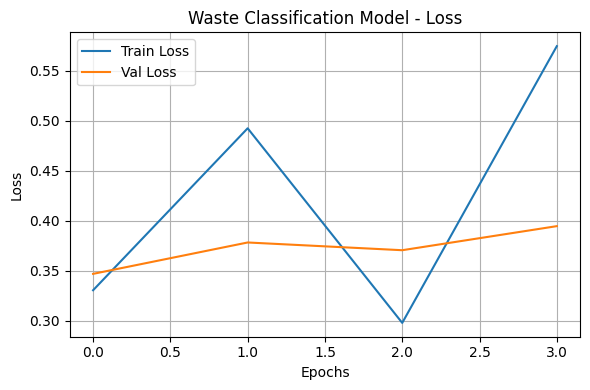

In [66]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Waste Classification Model - Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

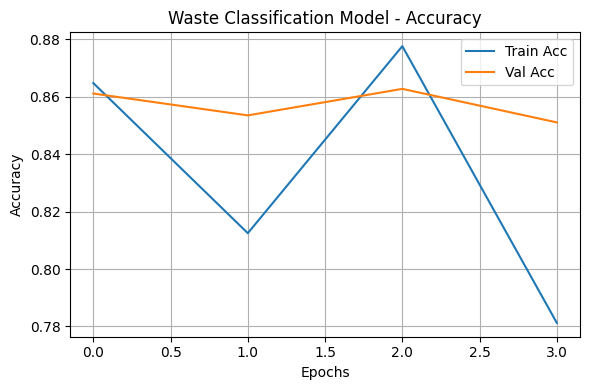

In [67]:
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Waste Classification Model - Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Metrics

In [68]:
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

Final Training Loss: 0.5744
Final Validation Loss: 0.3946
Final Training Accuracy: 0.7812
Final Validation Accuracy: 0.8511


Confusion matrices

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
true_labels = test_generator.classes
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())
cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
display(pd.DataFrame(cm, index=class_labels, columns=class_labels))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


116/116 ━━━━━━━━━━━━━━━━━━━━ 85s 721ms/step
Confusion Matrix:


organic  recyclable
organic        1867         215
recyclable      247        1378

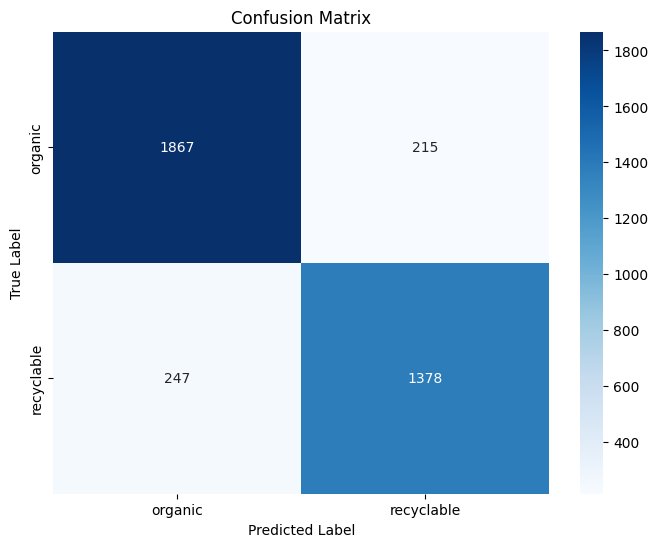

In [70]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()